# Bank Churn Modeling

### Table of Contents:
1) Feature Selection
2) Feature Correlation
3) Models

### 1) Feature Selection

In [1]:
# Setup using Edwin's code
import numpy as np
import pandas as pd
import datetime as dt
import copy

In [29]:
#-10000000000.0 needs to be dropped
outliers = c_df[(c_df['start_balance'] <= -100000.0)]
cust_df = c_df.drop(outliers.index)

4.04


In [2]:
c_df_original = pd.read_csv(r"C:\bank-churn-data\customers_tm1_e.csv")
c_df_original['start_balance'] = c_df_original['start_balance'].apply(lambda x: 0 if pd.isna(x) else x)
c_df_original.loc[c_df_original['start_balance'] < 0,'start_balance'] = 0
c_df_original.loc[c_df_original['start_balance'] >10000000,'start_balance'] = 0
c_df = c_df_original[:1000]
c_array = c_df.to_numpy()

# Convert customer data to transactional rows
c_to_t = pd.DataFrame()
c_to_t['date'] = c_df_original['creation_date']
c_to_t['account_id'] = 0
c_to_t['customer_id'] = c_df_original['customer_id']
c_to_t['amount'] = c_df_original['start_balance']
c_to_t['transaction_date'] = c_df_original['creation_date']
c_to_t['deposit'] = c_df_original['start_balance']#.apply(lambda x: 0 if pd.isna(x) else x)
c_to_t['withdrawal'] = 0

# Load transactional dataset
t_df_original = pd.read_csv(r"C:\bank-churn-data\transactions_tm1_e.csv")
t_df_original = pd.concat([c_to_t, t_df_original])
t_df = t_df_original.iloc[:1000]
t_array = t_df.to_numpy()

In [3]:
# Edwin's code
t_df_original['transaction_date'] = t_df_original['transaction_date'].apply(pd.to_datetime)
t_df_original = t_df_original.sort_values(by=['customer_id', 'transaction_date'])
t_df_original['month'] = t_df_original['transaction_date'].dt.month
t_df_original['year'] = t_df_original['transaction_date'].dt.year
t_df_original['deposit_y'] = t_df_original['deposit'].apply(lambda x: 1 if abs(x) > 0 else 0)
t_df_original['withdrawal_y'] = t_df_original['withdrawal'].apply(lambda x: 1 if abs(x) > 0 else 0)
t_df_original['checked_balance'] = t_df_original['amount'].apply(lambda x: 1 if abs(x) == 0 else 0)
t_df_original['time_since_last_trans'] = t_df_original.groupby('customer_id')['transaction_date'].diff()
t_df_original['time_since_last_trans_in_days'] = t_df_original['time_since_last_trans'].dt.total_seconds()/(60*60*24)

KeyboardInterrupt: 

In [8]:
## Griffen's reworking of Edwin's code
t_df_original['transaction_date'] = pd.to_datetime(t_df_original['transaction_date'])
t_df_original = t_df_original.sort_values(by=['customer_id', 'transaction_date'])
t_df_original['month'] = t_df_original['transaction_date'].dt.month
t_df_original['year'] = t_df_original['transaction_date'].dt.year
t_df_original['deposit_y'] = (t_df_original['deposit'].abs() > 0).astype(int)
t_df_original['withdrawal_y'] = (t_df_original['withdrawal'].abs() > 0).astype(int)
t_df_original['checked_balance'] = (t_df_original['amount'].abs() == 0).astype(int)
t_df_original['time_since_last_trans'] = t_df_original.groupby('customer_id')['transaction_date'].diff()
t_df_original['time_since_last_trans_in_days'] = t_df_original['time_since_last_trans'].dt.total_seconds()/(60*60*24)


In [9]:
t_df_grouped = t_df_original.groupby(
    ["customer_id","year","month"])['amount','deposit','withdrawal', 'deposit_y','withdrawal_y',
                                    'time_since_last_trans_in_days', 'checked_balance'].agg(
    sum_deposit = ("deposit","sum"),
    sum_withdrawal = ("withdrawal","sum"),
    count_deposit = ("deposit_y", "sum"),
    count_withdrawal = ("withdrawal_y", 'sum'),
    checked_balance = ("checked_balance",'max'),
    mean_time_between_trans = ("time_since_last_trans_in_days", "mean")
)

t_df_grouped['sum_delta'] = t_df_grouped['sum_deposit'] + t_df_grouped['sum_withdrawal']
t_df_grouped['mean_deposit'] = (
    t_df_grouped['sum_deposit']/t_df_grouped['count_deposit'].apply(lambda x:max(1,x)))
t_df_grouped['mean_withdrawal'] = (
    t_df_grouped['sum_withdrawal']/t_df_grouped['count_withdrawal'].apply(lambda x:max(1,x)))

t_df_grouped['running_balance'] = t_df_grouped.groupby('customer_id')['sum_delta'].cumsum()


C:\Users\GriffenRoweGaddis\AppData\Local\Temp\ipykernel_27236\250260605.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  t_df_grouped = t_df_original.groupby(


In [11]:
c_summary = t_df_original.groupby(
    "customer_id")['deposit','withdrawal', 'deposit_y', 'withdrawal_y','checked_balance',
                   'transaction_date','time_since_last_trans_in_days'].agg(
    total_deposits = ("deposit","sum"),
    total_withdrawals = ("withdrawal","sum"),
    num_deposit = ("deposit_y", "sum"),
    num_withdrawal = ("withdrawal_y", 'sum'),
    num_checked_balance = ("checked_balance",'max'),
    num_transactions = ('deposit','count'),
    first_transaction = ('transaction_date','first'),
    last_transaction = ('transaction_date','last'),
    mean_time_between_trans_in_days = ('time_since_last_trans_in_days','mean')
    )

c_summary['final_balance'] = c_summary['total_deposits'] + c_summary['total_withdrawals']
# act_lifespan - lifespan of account, time from first transaction to last transaction
c_summary['act_lifespan_in_days'] = c_summary['last_transaction'] - c_summary['first_transaction']
c_summary['act_lifespan_in_days'] = c_summary['act_lifespan_in_days'].dt.total_seconds()/(60*60*24) + 1
# time_since_last_trans - time between 2020-06-01 (end of data window) and last transaction of customer
c_summary['time_since_last_trans_in_days'] = pd.to_datetime('2020-06-01') - c_summary['last_transaction']
c_summary['time_since_last_trans_in_days'] = c_summary['time_since_last_trans_in_days'].dt.total_seconds()/(60*60*24)
c_summary['transactional_rate'] = c_summary['num_transactions']/c_summary['act_lifespan_in_days']
#c_summary['customer_id'] = c_summary.index
c_summary = c_summary.reset_index()


C:\Users\GriffenRoweGaddis\AppData\Local\Temp\ipykernel_27236\1166571417.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  c_summary = t_df_original.groupby(


In [12]:
# Create response variable (labeling)
last_date = pd.to_datetime('2019-12-31')
c_summary['churn'] = np.where(c_summary['last_transaction'] < last_date,1,0)

In [13]:
# Load in fed funds rate data
ir_df = pd.read_csv(r"C:\bank-churn-data\FEDFUNDS.csv")
ir_df['DATE'] = pd.to_datetime(ir_df['DATE'])
ir_df['month'] = ir_df['DATE'].dt.month
ir_df['year'] = ir_df['DATE'].dt.year
display(ir_df)

,DATE,FEDFUNDS,month,year
0,1954-07-01,0.80,7,1954
1,1954-08-01,1.22,8,1954
2,1954-09-01,1.07,9,1954
3,1954-10-01,0.85,10,1954
4,1954-11-01,0.83,11,1954
...,...,...,...,...
822,2023-01-01,4.33,1,2023
823,2023-02-01,4.57,2,2023
824,2023-03-01,4.65,3,2023
825,2023-04-01,4.83,4,2023


In [14]:
# Merge with c_summary. Create feature that is interest rate at last transaction date.
c_summary['last_trans_month'] = c_summary['last_transaction'].dt.month
c_summary['last_trans_year'] = c_summary['last_transaction'].dt.year
c_summary = pd.merge(c_summary, ir_df, left_on=['last_trans_month', 'last_trans_year'], right_on=['month','year'])


In [16]:
c_summary = c_summary.drop(['DATE','month','year'],axis=1)

In [17]:
# create net_total_trans column
c_summary['net_total_trans'] = c_summary['total_deposits'] + c_summary['total_withdrawals']

In [18]:
# get age of customers from c_df
c_summary = pd.merge(c_summary, c_df_original[['customer_id','dob']], on=['customer_id'])
c_summary['dob'] = pd.to_datetime(c_summary['dob'])
c_summary['age_at_last_trans'] = ((c_summary['last_transaction'] - c_summary['dob'])/np.timedelta64(1, 'Y')).astype(int)

In [19]:
# normalize deposit total and withdrawal total and take ratio
c_summary['total_deposits_normalized'] = (c_summary['total_deposits'] - c_summary['total_deposits'].min()) /(c_summary['total_deposits'].max() - c_summary['total_deposits'].min())
c_summary['total_withdrawals_pos'] = c_summary['total_withdrawals'] *-1
c_summary['total_withdrawals_normalized'] = (c_summary['total_withdrawals_pos'] - c_summary['total_withdrawals_pos'].min()) /(c_summary['total_withdrawals_pos'].max() - c_summary['total_withdrawals_pos'].min())
c_summary['d_w_normalized_ratio'] =  c_summary['total_withdrawals_normalized']/ c_summary['total_deposits_normalized'] 

In [23]:
display(c_summary)

,customer_id,total_deposits,total_withdrawals,num_deposit,num_withdrawal,num_checked_balance,num_transactions,first_transaction,last_transaction,mean_time_between_trans_in_days,...,last_trans_month,last_trans_year,FEDFUNDS,net_total_trans,dob,age_at_last_trans,total_deposits_normalized,total_withdrawals_pos,total_withdrawals_normalized,d_w_normalized_ratio
0,91,13214.82,-5295.18,2,1,1,7,2007-01-16,2007-03-30,12.166667,...,3,2007,5.26,7919.64,1993-07-01,13,0.024161,5295.18,1.235761e-02,0.511460
1,115,4528.27,-1442.37,2,4,1,13,2007-01-08,2007-03-29,6.666667,...,3,2007,5.26,3085.90,1987-10-20,19,0.008279,1442.37,3.366126e-03,0.406571
2,121,5405.44,0.00,1,0,1,4,2007-01-30,2007-03-31,20.000000,...,3,2007,5.26,5405.44,1992-03-31,14,0.009883,-0.00,0.000000e+00,0.000000
3,132,11255.58,-9821.09,4,7,0,11,2007-01-24,2007-03-31,6.600000,...,3,2007,5.26,1434.49,1992-06-09,14,0.020579,9821.09,2.291993e-02,1.113740
4,183,12220.79,-8641.39,4,7,0,11,2007-01-07,2007-03-31,8.300000,...,3,2007,5.26,3579.40,1982-12-22,24,0.022344,8641.39,2.016681e-02,0.902560
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
116011,112212,139.28,0.00,1,0,1,4,2020-01-24,2020-01-31,2.333333,...,1,2020,1.55,139.28,1987-08-22,32,0.000255,-0.00,0.000000e+00,0.000000
116012,112325,7728.41,-3325.03,2,2,0,4,2020-01-06,2020-01-31,8.333333,...,1,2020,1.55,4403.38,1984-12-03,35,0.014130,3325.03,7.759776e-03,0.549158
116013,112330,0.84,-0.37,2,1,0,3,2020-01-19,2020-01-31,6.000000,...,1,2020,1.55,0.47,1992-04-12,27,0.000002,0.37,8.634861e-07,0.562230
116014,112405,12697.62,0.00,2,0,0,2,2020-01-31,2020-01-31,0.000000,...,1,2020,1.55,12697.62,1951-02-07,68,0.023216,-0.00,0.000000e+00,0.000000


In [24]:
# Take squares of mean_time_between_trans_in_days, final_balance, time_since_last_trans_in_days,
# transactional_rate, FEDFUNDS, net_total_trans
print(c_summary.columns.values)
c_summary['time_between_trans**2'] = c_summary['mean_time_between_trans_in_days'] ** 2
c_summary['final_bal**2'] = c_summary['final_balance'] ** 2
c_summary['trans_rate**2'] = c_summary['transactional_rate'] ** 2
c_summary['fed_funds**2'] = c_summary['FEDFUNDS'] ** 2
c_summary['net_total_trans**2'] = c_summary['net_total_trans'] ** 2


['customer_id' 'total_deposits' 'total_withdrawals' 'num_deposit'
 'num_withdrawal' 'num_checked_balance' 'num_transactions'
 'first_transaction' 'last_transaction' 'mean_time_between_trans_in_days'
 'final_balance' 'act_lifespan_in_days' 'time_since_last_trans_in_days'
 'transactional_rate' 'churn' 'last_trans_month' 'last_trans_year'
 'FEDFUNDS' 'net_total_trans' 'dob' 'age_at_last_trans'
 'total_deposits_normalized' 'total_withdrawals_pos'
 'total_withdrawals_normalized' 'd_w_normalized_ratio']


In [14]:
# get list of all data frames in memory
alldfs = [var for var in dir() if isinstance(eval(var), pd.core.frame.DataFrame)]
print(alldfs) # need to use c_summary, t_df_original, fedfunds, t_df_grouped
# note that we are missing state in c_summary

['c_df', 'c_df_original', 'c_summary', 'c_to_t', 'ir_df', 't_df', 't_df_grouped', 't_df_original']


#### Features for model:
- State dummies
- Age of customer at last transaction date 
- time_since_last_trans_in_days (done)
- mean_time_between_trans_in_days (done)
- act_lifespan_in_days (done)
- Net transaction amount: total_deposits + total_withdrawals (done)
- Interest rate (done)
- Inflation rate (maybe)
- Whether they have had a transaction for last 3 months
- Whether their ending balance was positive for last 3 months
- Ratio of deposits to withdrawals (done-ish)


#### New features:
- Square random things, also maybe log of some things
- transaction_rate for last 3 months of activity/ average transactional rate over entire account lifespan
- Normalized deposit amounts / normalized withdrawal amounts

In [27]:
pd.set_option('display.max_columns', None)
print(c_summary.corr())

C:\Users\GriffenRoweGaddis\AppData\Local\Temp\ipykernel_27236\796146733.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  print(c_summary.corr())


                                 customer_id  total_deposits  \
customer_id                         1.000000       -0.081023   
total_deposits                     -0.081023        1.000000   
total_withdrawals                   0.084973       -0.976850   
num_deposit                        -0.109250        0.719420   
num_withdrawal                     -0.101527        0.676327   
num_checked_balance                -0.078414        0.239609   
num_transactions                   -0.112170        0.703466   
mean_time_between_trans_in_days    -0.059122        0.159158   
final_balance                      -0.027861        0.610140   
act_lifespan_in_days               -0.111121        0.714464   
time_since_last_trans_in_days      -0.930066       -0.174920   
transactional_rate                  0.090438       -0.133202   
churn                              -0.575340       -0.135108   
last_trans_month                   -0.097367       -0.017319   
last_trans_year                     0.92

In [49]:
print(c_summary.columns.values)

['customer_id' 'total_deposits' 'total_withdrawals' 'num_deposit'
 'num_withdrawal' 'num_checked_balance' 'num_transactions'
 'first_transaction' 'last_transaction' 'mean_time_between_trans_in_days'
 'final_balance' 'act_lifespan_in_days' 'time_since_last_trans_in_days'
 'transactional_rate' 'churn' 'last_trans_month' 'last_trans_year'
 'FEDFUNDS' 'net_total_trans' 'dob_x' 'age_at_last_trans'
 'total_deposits_normalized' 'total_withdrawals_pos'
 'total_withdrawals_normalized' 'd_w_normalized_ratio'
 'time_between_trans**2' 'final_bal**2' 'time_since_last**2'
 'trans_rate**2' 'fed_funds**2' 'net_total_trans**2']


C:\Users\GriffenRoweGaddis\AppData\Local\Temp\ipykernel_27236\893196133.py:15: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  heatmap = sns.heatmap(subset_df.corr(),vmin=-1, vmax=1, annot=True, linewidths=1)


Text(0.5, 1.0, 'Correlation Heatmap')

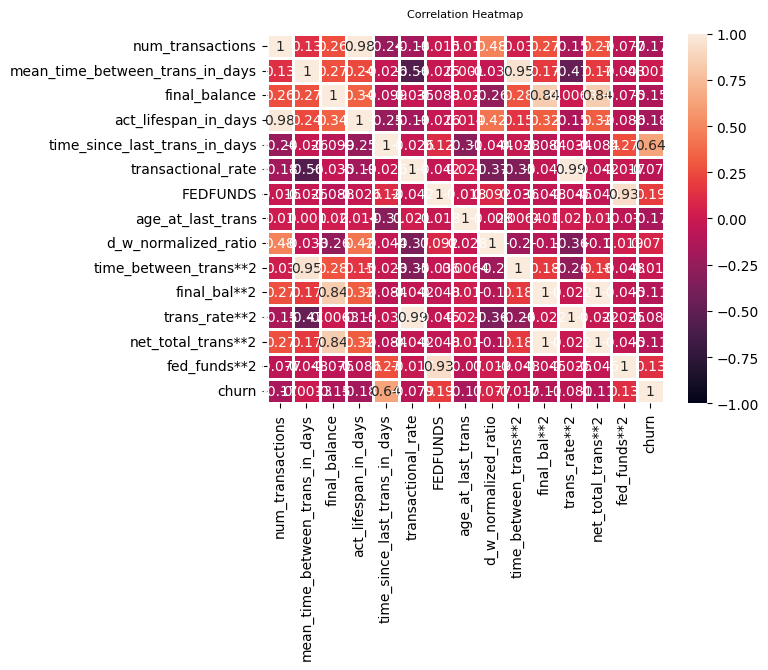

In [26]:
# c_summary correlation matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming 'df' is your DataFrame containing the columns
selected_columns = ['num_transactions','last_transaction', 'mean_time_between_trans_in_days', 'final_balance',
                    'act_lifespan_in_days', 'time_since_last_trans_in_days', 'transactional_rate', 
                    'FEDFUNDS', 'age_at_last_trans','d_w_normalized_ratio', 'time_between_trans**2',
                    'final_bal**2', 'trans_rate**2', 'net_total_trans**2', 'fed_funds**2','churn']

# Subset the DataFrame with the selected columns
subset_df = c_summary[selected_columns]

# Calculate correlation matrix
heatmap = sns.heatmap(subset_df.corr(),vmin=-1, vmax=1, annot=True, linewidths=1)
heatmap.set_title('Correlation Heatmap', fontdict={'fontsize':8}, pad=12)

### Models
- Logistic Regression
- LDA, QDA
- Naive Bayes
- Decision Trees
- Random Forest
- Neural Net

In [49]:
# Split the data
from sklearn.model_selection import train_test_split
features = ['time_since_last_trans_in_days','act_lifespan_in_days','FEDFUNDS','age_at_last_trans','num_transactions']
features2 = ['act_lifespan_in_days','FEDFUNDS','age_at_last_trans','num_transactions']

csumm_train, csumm_test = train_test_split(c_summary, test_size=0.2,random_state=1)

X_train = csumm_train[features]
y_train = csumm_train['churn']

X_test = csumm_test[features]
y_test = csumm_test['churn']

#### Logistic Regression

In [50]:
# Fit logistic regression model
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score

logit = LogisticRegression().fit(X_train,y_train)
y_logit_pred = logit.predict(X_test)

# Evaluate model
acc_score = accuracy_score(y_test, y_logit_pred)
print(f'Accuracy score is {acc_score}')

pr = precision_score(y_test, y_logit_pred)
print(f'Precision is {pr}')

re = recall_score(y_test, y_logit_pred)
print(f'Recall is {re}')

Accuracy score is 0.9994397517669368
Precision is 1.0
Recall is 0.9993153210091115


c:\Users\GriffenRoweGaddis\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


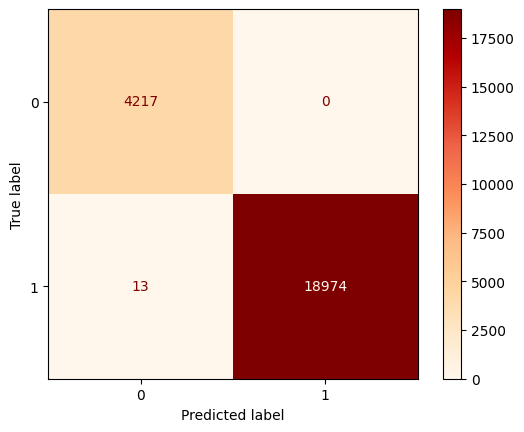

In [51]:
# Create confusion matrix
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
cm = confusion_matrix(y_test, y_logit_pred)

cm_plot = ConfusionMatrixDisplay(cm)
cm_plot.plot(cmap="OrRd")
plt.show()

#### Linear Discriminant Analysis

In [52]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.metrics import accuracy_score, precision_score, recall_score

logit = LinearDiscriminantAnalysis().fit(X_train,y_train)
y_lda_pred = logit.predict(X_test)

# Evaluate model
acc_score = accuracy_score(y_test, y_lda_pred)
print(f'Accuracy score is {acc_score}')

pr = precision_score(y_test, y_lda_pred)
print(f'Precision is {pr}')

re = recall_score(y_test, y_lda_pred)
print(f'Recall is {re}')

Accuracy score is 0.9866402344423375
Precision is 0.9889011046542066
Recall is 0.9948385737609944


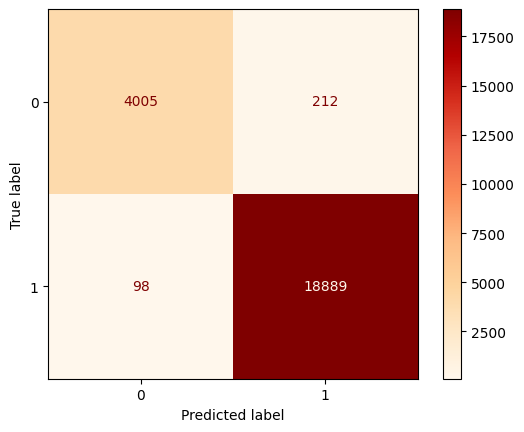

In [53]:
cm = confusion_matrix(y_test, y_lda_pred)

cm_plot = ConfusionMatrixDisplay(cm)
cm_plot.plot(cmap="OrRd")
plt.show()

#### Naive Bayes

In [54]:
from sklearn.naive_bayes import GaussianNB

logit = GaussianNB().fit(X_train,y_train)
y_nb_pred = logit.predict(X_test)

# Evaluate model
acc_score = accuracy_score(y_test, y_nb_pred)
print(f'Accuracy score is {acc_score}')

pr = precision_score(y_test, y_nb_pred)
print(f'Precision is {pr}')

re = recall_score(y_test, y_nb_pred)
print(f'Recall is {re}')

Accuracy score is 0.9844423375280124
Precision is 0.981540847983454
Recall is 0.9997893295412651


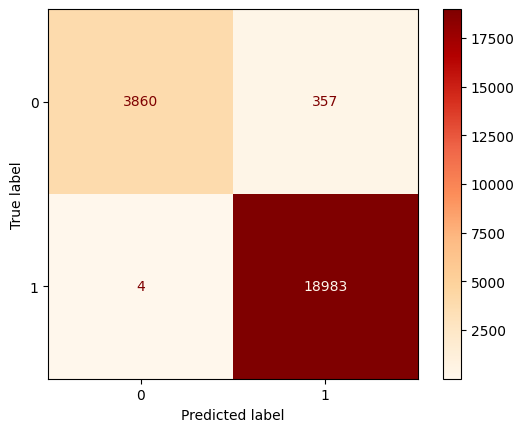

In [55]:
cm = confusion_matrix(y_test, y_nb_pred)

cm_plot = ConfusionMatrixDisplay(cm)
cm_plot.plot(cmap="OrRd")
plt.show()

#### Decision Tree

In [62]:
from sklearn.tree import DecisionTreeClassifier

dtc = DecisionTreeClassifier(random_state=0) # this way overfits the data
dtc.fit(X_train,y_train)

DecisionTreeClassifier(random_state=0)

Accuracy score is 1.0
Precision is 1.0
Recall is 1.0


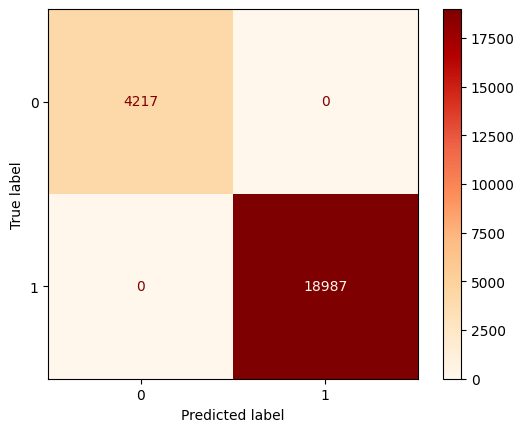

In [63]:
y_dtc_pred = dtc.predict(X_test)
acc_score = accuracy_score(y_test, y_dtc_pred)
print(f'Accuracy score is {acc_score}')

pr = precision_score(y_test, y_dtc_pred)
print(f'Precision is {pr}')

re = recall_score(y_test, y_dtc_pred)
print(f'Recall is {re}')

cm = confusion_matrix(y_test, y_dtc_pred)

cm_plot = ConfusionMatrixDisplay(cm)
cm_plot.plot(cmap="OrRd")
plt.show()